# Analyzing Time Series Data w.r.t COVID19 cases and casualities around the world

## Importing Necessary Libraries

In [253]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go
from IPython.display import Image

## Static Information

In [254]:
confirmed_global = 'data/time_series_covid19_confirmed_global.csv'
deaths_global = 'data/time_series_covid19_deaths_global.csv'
recovered_global = 'data/time_series_covid19_recovered_global.csv'
static_cols = ['Province/State', 'Country/Region', 'Lat', 'Long']
years = ['20','21','22']
months_mapping = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
century = '20'
this_year = datetime.today().strftime("%y")
this_month = int(datetime.today().strftime("%m"))
months = [i for i in range(1,13)]

In [255]:
#data preparation
confirmed_global_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
deaths_global_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


## Helper functions needed

In [256]:
def import_data(path):
    """imports the data from csv into pandas dataframe

    Args:
        path (str): path where the csv file is present

    Returns:
        dataframe: loaded pandas dataframe is returned
    """
    df = pd.read_csv(path)
    return df 



In [257]:
def process_data():
    """downloads latest covid data

    """
    confirmed_global_pre = import_data(confirmed_global_url)
    confirmed_global_pre.to_csv(confirmed_global)
    deaths_global_pre = import_data(deaths_global_url)
    deaths_global_pre.to_csv(deaths_global)   

In [258]:
def get_daily_counts(cumulative_df):
    """obtains the daily count increment from a df with cumulative count increments. This is used for plotting the way the cases have increased/decreased over time.

    Args:
        cumulative_df (dataframe): time series dataframe with cumulative increment in values everyday

    Returns:
        dataframe: dataframe with individual increments/decrements per day
    """
    confirmed_df_testing = cumulative_df.copy()    
    c_diff_df = pd.DataFrame()
    for i in range(0, len(confirmed_df_testing.columns)-1):
        if confirmed_df_testing.columns[i] not in static_cols:
            c_diff_df[confirmed_df_testing.columns[i]] = confirmed_df_testing[confirmed_df_testing.columns[i+1]].astype(int) - confirmed_df_testing[confirmed_df_testing.columns[i]].astype(int)
    return c_diff_df

In [259]:
def create_monthly_analysis(df, retain_extra_columns = False, end_month = None, streamline_data=True):
    """create monthly data by aggregating daily time series data, also finding the global and total from both axes of the monthly counts

    Args:
        df (dataframe): input dataframe which contains the cumulative daily count info for different countries.
        retain_extra_columns (bool) : retains the static columns incase of further analysis; (optional) default False
        end_month (str) : get the months data only till end_month if specified; (optional) default None
        streamline_data (bool) : streamline data by removing rows with Nan; (optional) default True

    Returns:
        dataframe: dataframe which contains monthly count of covid cases for different countries as well as global,
                    also contains the tilldate column which shows cumulative of all cases till now for different countries as well as global.
    """
    
    # removing duplicate and Nan items
    if streamline_data:
        df = df.fillna('')
        df = df[df['Province/State']=='']
    
    #gets the individual day count instead of cumulative counts
    df_months = get_daily_counts(df)
    
    current_year = 0
    condition_stop = 0
    monthly_df = pd.DataFrame(df['Country/Region'], columns = ['Country/Region'])
    
    # creates the monthly counts from daily count till current month
    for year in years:
        # print("YEAR", year)
        if condition_stop == 1:
            break
        if year == this_year:
            current_year = 1
        for month in months:
            # print("MONTH", month)
            if current_year == 1 and month == this_month+1:
                condition_stop = 1
                break
            str_date_month = months_mapping[month] + ' ' +str(century)+str(year)
            if end_month == str_date_month:
                condition_stop = 1
                break
            monthly_df[str_date_month] = 0
            cum_count = 0
            for i in df_months.columns:
                def match(datematch, input_string):
                    date = re.compile(datematch)
                    matched = date.search(input_string)
                    return matched
                datematch = rf"\b{month}\b/\d{{1,2}}/{year}"
                datematch_fullyear = rf"\b{month}\b/\d{{1,2}}/{century+year}"
                matched = match(datematch, str(i))
                matched_fullyear = None 
                if matched != None or matched_fullyear != None:
                    cum_count = df_months[i][0].astype(int) + cum_count  
                    monthly_df[str_date_month] = df_months[i].astype(int) + monthly_df[str_date_month]
                
            
    #if True retains extra columns for further analysis
    if retain_extra_columns == True:
        for col in static_columns:
            monthly_df[col] = df[col]
    
    monthly_df = monthly_df.set_index('Country/Region')

    #Obtain the count for entire world for different months 
    monthly_df.loc['global',:]= monthly_df.sum(axis=0)
    
    #Obtain the count of total cases till current date for individual countries as well as whole world
    monthly_df.loc[:,'tilldate'] = monthly_df.sum(axis=1)

    return monthly_df

In [260]:
def plot_line_graph(x, y, title, xlabel, ylabel, color='blue', rotation=0, subplot_num=None, axis = None, fillcolor='skyblue', figsize=(10,5), scale = None): 
    """plots the line graph based on input parameters

    Args:
        x (dataframe): data to be plotted on x axis
        y (dataframe): data to be plotted on y axis      
        title (str) : title of the plot
        xlabel (str) : description of x axis
        ylabel (str) : description of y axis
        color (str) : color of the line plot
        rotation (str) : rotation of xlabels
        subplot_num (str) : subplot number if any 
        axis (str) : predefined figure axis if any
        fillcolor (str) : fillcolor inside line plot
        figsize (str) : size of the plot
        scale (str) : scale of y axis values eg: 'M', 'K'        

    Returns:
        plot: line graph with mentioned parameters
    """
    if axis == None:
        figure, axis = plt.subplots(1, 1, figsize=figsize)
    if subplot_num != None:
        axis = axis[subplot_num]
    axis.plot(x, y, color =color)
    axis.set_title(title)
    plt.setp(axis.get_xticklabels(), rotation=rotation)
    plt.fill_between(x, y, alpha=0.4, color=fillcolor)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    current_values = plt.gca().get_yticks()
    if scale == None:
        axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
    elif scale == 'K':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
    elif scale == 'M':
        axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
    plt.show()
 

In [261]:
def addlabels(inp_x, inp_y, axis, scale = None, orient='h', label_pushup_mag = 100):
    """add labels to bar graph based on the parameters
    
    Args:
        inp_x (collection): data to be plotted on x axis
        inp_y (collection): data to be plotted on y axis      
        axis (str) : the bar plot axis
        label_pushup_mag (str) : position of the labels on bar graph
        orient (str) : orientation of the bar plot
        scale (str) : scale of y axis values eg: 'M', 'K'        

    Returns:
        plot: labelled bar plot
    """
    if orient == 'h':
        x = inp_y
        y = inp_x
        for i in range(len(y)):
            if x[i] <= 10 :            
                x_pos = x[i] + label_pushup_mag
            else:
                x_pos = x[i]
            if scale == None:
                x_values = [int(i) for i in x]
            elif scale == 'K':
                x_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in x]
            elif scale == 'M':
                x_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in x]
            axis.text(x_pos, i, x_values[i], ha = 'right')        
    else:
        x = inp_x
        y = inp_y
        for i in range(len(x)):
            if y[i] <= 10 :            
                y_pos = y[i] + label_pushup_mag
            else:
                y_pos = y[i]
            if scale == None:
                y_values = [int(i) for i in y]
            elif scale == 'K':
                y_values = ['{:,.0f}'.format(i/1E3) + 'K' for i in y]
            elif scale == 'M':
                y_values = ['{:,.0f}'.format(i/1E6) + 'M' for i in y]
            axis.text(i, y_pos, y_values[i], ha = 'center')

In [262]:
def plot_bar_graph(x, y, title, xlabel, ylabel, color='blue', rotation=0, width = 0.8, axis =None, subplot_num=None, figsize=(10,5), scale = None, add_labels = True, orient='h', label_pushup_mag=100):
    """plots the line graph based on input parameters

    Args:
        x (dataframe): data to be plotted on x axis
        y (dataframe): data to be plotted on y axis      
        title (str) : title of the plot
        xlabel (str) : description of x axis
        ylabel (str) : description of y axis
        color (str) : color of the line plot
        rotation (str) : rotation of xlabels
        subplot_num (str) : subplot number if any 
        axis (str) : predefined figure axis if any
        fillcolor (str) : fillcolor inside line plot
        figsize (str) : size of the plot
        scale (str) : scale of y axis values eg: 'M', 'K'  
        label_pushup_mag (str) : position of the labels on bar graph
        orient (str) : orientation of the bar plot
        add_labels (str) : flag to add labels
        width (numeric) : width between the bars in the plot

    Returns:
        plot: bar graph with mentioned parameters
    """

    if orient == 'h':          
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.barh(y=x, width=y, color = color, height = width)
        axis.set_title(title)
        # plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_xticks()
        if scale == None:
            axis.set_xticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_xticks()])
        elif scale == 'K':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_xticks()/1E3])
        elif scale == 'M':
            axis.set_xticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_xticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient, label_pushup_mag=label_pushup_mag)
        plt.show()
    else:
        if axis == None:
            figure, axis = plt.subplots(1, 1, figsize=figsize)
        if subplot_num != None:
            axis = axis[subplot_num]
        axis.bar(x, y, color = color, width = width)
        axis.set_title(title)
        plt.setp(axis.get_xticklabels(), rotation=rotation)
        axis.set_xlabel(xlabel)
        axis.set_ylabel(ylabel)
        current_values = plt.gca().get_yticks()
        if scale == None:
            axis.set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()])
        elif scale == 'K':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'K' for x in plt.gca().get_yticks()/1E3])
        elif scale == 'M':
            axis.set_yticklabels(['{:,.0f}'.format(x) + 'M' for x in plt.gca().get_yticks()/1E6])
        if add_labels:
            addlabels(x, y, axis, scale = scale, orient = orient, label_pushup_mag=label_pushup_mag)
        plt.show()

In [263]:
def plotting_pie_chart(data, labels, explode_list, title, figsize): 
    """plots the pie graph based on input parameters

    Args:
        data (dataframe): data to be plotted
        labels (dataframe): labels for the data plotted    
        explode_list (list) : list of sectors to be exploded
        figsize (str) : size of the plot
        title (str) : title of the plot

    Returns:
        plot: pie chart plotted
    """
    plt.figure(figsize=figsize)
    plt.pie(x = data, labels = labels, autopct='%1.1f%%', explode=explode_list, pctdistance=0.80)
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    plt.title(title)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.show()

In [264]:
def plot_world_scatterplot(longitude, latitude, labels, title, dest_path, colorbar_title):
    """plots the world map with values scatter plot

    Args:
        longitude (dataframe): longitude data
        latitude (dataframe): latitude data   
        labels (dataframe): labels for the data plotted appears on hover
        dest_path (str) : path where html of plot is saved
        colorbar_title (str) : title of the color bar
        title (str) : title of the plot

    Returns:
        plot: world map with scatter plot
    """
    fig = go.Figure(data = go.Scattergeo(
        lon = longitude,
        lat = latitude,
        text = labels,
        mode = "markers",
        marker = dict(
            size = 10,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = True,
            symbol = 'circle',
            line = dict(
                width = 1,
                color = 'rgba(102, 102, 102)'
            ),
            cmin = 0,
            color = wm_df[last_date],
            cmax = wm_df[last_date].max(),
            colorbar_title = colorbar_title)
        ))
    fig.update_layout(
    title = title,
    geo = dict(
        scope = "world",
        showland = True,
        )
    )

    fig.write_html(dest_path, auto_open=True)
    

## Processing data 

In [265]:
#process_data()

## Loading Time series  Data

In [266]:
#loading the data
confirmed_df = import_data(confirmed_global)
deaths_df = import_data(deaths_global)
recovered_df = import_data(recovered_global)

In [267]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/7/2022,3/8/2022,3/9/2022,3/10/2022,3/11/2022,3/12/2022,3/13/22,3/14/22,3/15/22,3/16/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,175000,175353,175525,175893,175974,176039,176201,176409,176571,176743
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,272250,272337,272412,272479,272552,272621,272663,272689,272711,272804
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,265297,265323,265346,265366,265391,265410,265432,265457,265478,265496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,38620,38710,38794,38794,38794,38794,38794,38794,38794,38794
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,98806,98829,98855,98855,98855,98909,98927,98931,98956,98985


## Creating monthly analysis for confirmed cases and deaths observed

In [268]:
confirmed_monthly = create_monthly_analysis(confirmed_df)

In [269]:
deaths_monthly = create_monthly_analysis(deaths_df)

In [270]:
# the data obtained wrt recoveries is not consistent throughout so slicing till August 2021.
recovered_monthly = create_monthly_analysis(recovered_df, end_month = 'Aug 2021', streamline_data=False)

### Creating global time series data 

In [271]:
#creating monthly aggregates for confirmed, casualities and recoveries 
global_table = pd.DataFrame(columns = confirmed_monthly.columns)
global_table = global_table.drop(columns = ['tilldate'], axis = 1)
global_table.loc['confirmed'] = confirmed_monthly.loc['global']
global_table.loc['deaths'] = deaths_monthly.loc['global']
global_table.loc['recoveries'] = recovered_monthly.loc['global']
global_table.head()

,Jan 2020,Feb 2020,Mar 2020,Apr 2020,May 2020,Jun 2020,Jul 2020,Aug 2020,Sep 2020,Oct 2020,...,Jun 2021,Jul 2021,Aug 2021,Sep 2021,Oct 2021,Nov 2021,Dec 2021,Jan 2022,Feb 2022,Mar 2022
confirmed,39329262.0,34782544.0,25342127.0,10245938.0,11896026.0,9167239.0,12322770.0,15835622.0,15338910.0,17122439.0,...,6672784.0,10518187.0,12163820.0,9008205.0,8073258.0,10122806.0,18687351.0,61018247.0,26589890.0,5783197.0
deaths,235883.0,285101.0,240156.0,334332.0,304340.0,271418.0,270728.0,302021.0,278215.0,262959.0,...,151424.0,173950.0,185816.0,152491.0,131440.0,129942.0,128169.0,164727.0,146935.0,13983.0
recoveries,257.0,42434.0,150354.0,858714.0,1640243.0,2776392.0,5085119.0,6527836.0,6820066.0,7201824.0,...,11264827.0,9985913.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### PLotting the global trends 

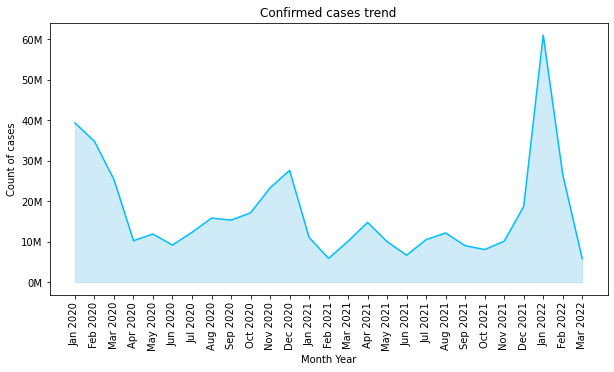

In [272]:
# plotting the trend of world confirmed cases count per month
plot_line_graph(global_table.columns, global_table.loc['confirmed'].values.tolist(),'Confirmed cases trend', 'Month Year', 'Count of cases', color='deepskyblue', rotation='90', fillcolor='skyblue', scale = "M")

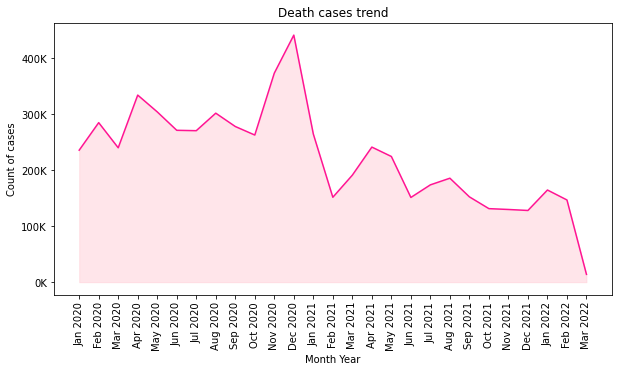

In [273]:
# plotting the trend of world death cases count per month
plot_line_graph(global_table.columns, global_table.loc['deaths'].values.tolist(),'Death cases trend', 'Month Year', 'Count of cases', color='deeppink', rotation='90', fillcolor='pink', scale = 'K')

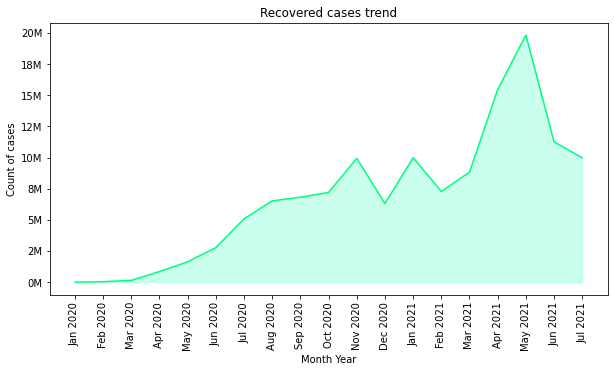

In [274]:
# plotting the trend of world recovered cases count per month
plot_line_graph(global_table.columns, global_table.loc['recoveries'].values.tolist(),'Recovered cases trend', 'Month Year', 'Count of cases', color='springgreen', rotation='90', fillcolor='aquamarine', scale = 'M')


### Obtaining country wise summary figures

In [275]:
# obtaining the country wise counts over months
country_wise_total_df = pd.DataFrame(columns=['confirmed'])
country_wise_total_df['confirmed'] = confirmed_monthly['tilldate']
country_wise_total_df = country_wise_total_df.join(pd.DataFrame(deaths_monthly['tilldate']))
country_wise_total_df = country_wise_total_df.rename(columns={"tilldate":"deaths"})
country_wise_total_df = country_wise_total_df.drop('global')
country_wise_total_df = country_wise_total_df.drop('Winter Olympics 2022')
country_wise_total_df = country_wise_total_df.drop('Summer Olympics 2020')

#### Plotting top 10 most affected countries

In [276]:
top_affected_countries = country_wise_total_df['confirmed'].sort_values(ascending = False).head(10)

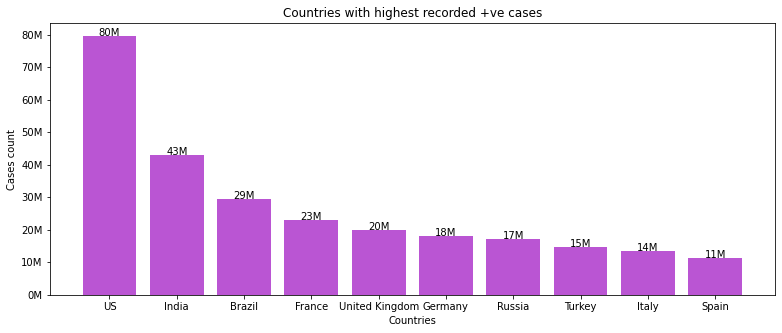

In [277]:
plot_bar_graph(top_affected_countries.index, top_affected_countries.values.tolist(), 'Countries with highest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', scale = 'M',figsize=(13,5), orient = 'v')

#### Plotting top 10 least affected countries

In [278]:
least_affected_countries = country_wise_total_df['confirmed'].sort_values(ascending = True).head(10)

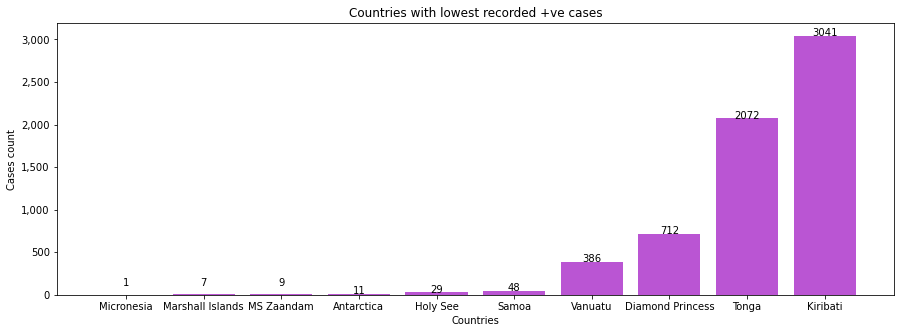

In [279]:
plot_bar_graph(least_affected_countries.index, least_affected_countries.values.tolist(), 'Countries with lowest recorded +ve cases', 'Countries', 'Cases count', color='mediumorchid', figsize=(15,5), orient = 'v')

#### Plotting top 10 countries with most casualities

In [280]:
top_deaths_countries = country_wise_total_df['deaths'].sort_values(ascending = False).head(10)

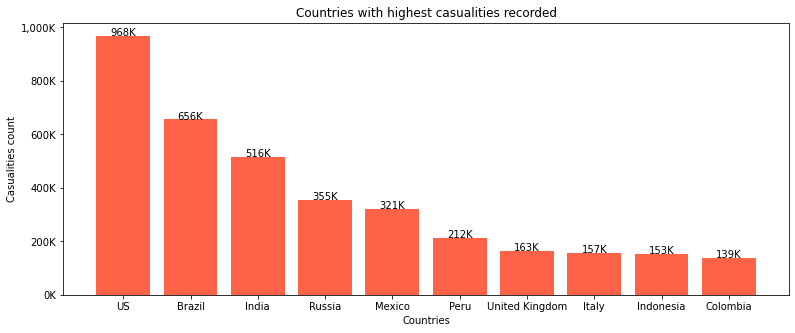

In [281]:
plot_bar_graph(top_deaths_countries.index, top_deaths_countries.values.tolist(), 'Countries with highest casualities recorded', 'Countries', 'Casualities count', color='tomato', orient='v', scale = 'K', figsize=(13,5))

#### Plotting top 10 countries with least casualities

In [282]:
least_deaths_countries = country_wise_total_df['deaths'].sort_values(ascending = True).head(10)

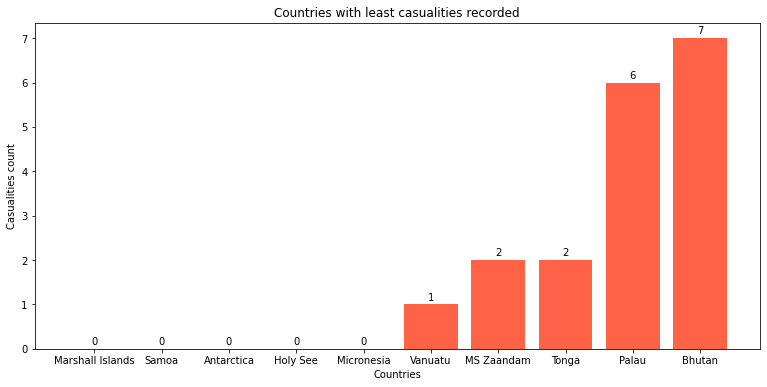

In [283]:
plot_bar_graph(least_deaths_countries.index, least_deaths_countries.values.tolist(), 'Countries with least casualities recorded', 'Countries', 'Casualities count', color='tomato', orient='v', width=0.8, figsize=(13,6), label_pushup_mag =0.1)

#### Checking the contribution of top countries in the entire worlds cases


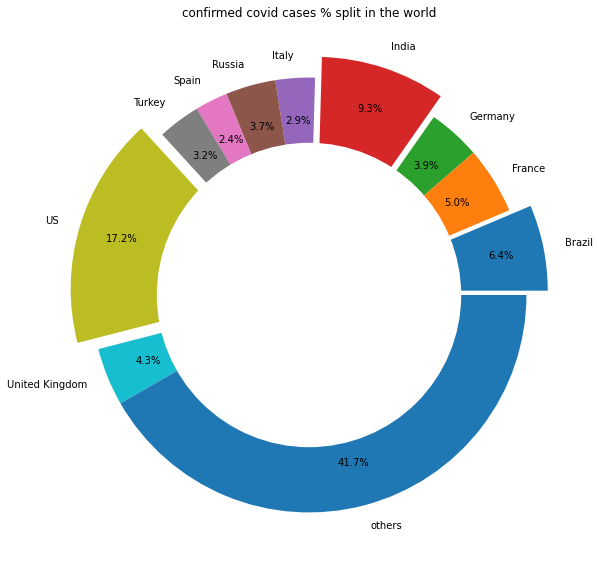

In [284]:
confirmed_cases = country_wise_total_df['confirmed']
compressed_conf = confirmed_cases[confirmed_cases<np.percentile(confirmed_cases, 95)].sum()
non_compressed_conf = confirmed_cases[confirmed_cases>=np.percentile(confirmed_cases, 95)]
non_compressed_conf['others'] = compressed_conf

explode_list = [0.1 if (non_compressed_conf[i]/non_compressed_conf.sum())*100 > 5 else 0 for i in range(0,len(non_compressed_conf)-1)]
explode_list.append(0)
plotting_pie_chart(non_compressed_conf, non_compressed_conf.index, explode_list, 'confirmed covid cases % split in the world', (10,10))

#### plotting world map with cases count till date

In [285]:
last_date = confirmed_df.columns[-1]
wm_df = confirmed_df.rename(columns= {"Country/Region" : "Country", "Province/State": "Province"})
wm_df['text'] = wm_df['Country'] + " " + wm_df[last_date].astype(str)

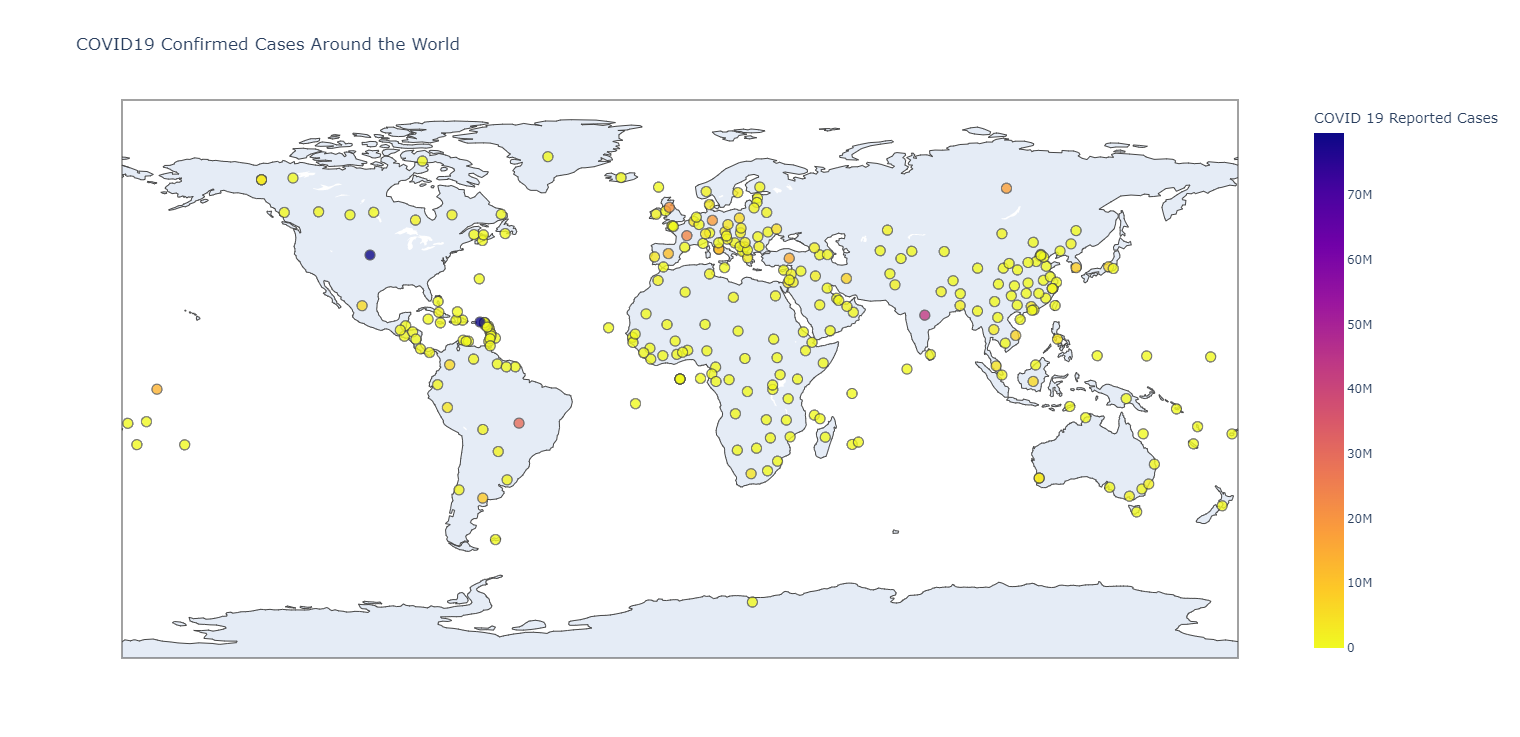

In [286]:
plot_world_scatterplot(wm_df["Long"], wm_df["Lat"], wm_df["text"], "COVID19 Confirmed Cases Around the World", 'artifacts/world_map_dist.html', "COVID 19 Reported Cases")

Image(filename='artifacts/world_map_dist.png')